**The Quantum Convolution Neural Network**
(It has been altered from the original)

Components of a QCNN

Data Generation

Building a QCNN

Training our QCNN

Testing our QCNN

In [1]:
# Md. Mehedi Hasan
# B.Sc.(Honours) in Applied Mathematics
# Faculty of Science
# Noakhali Science and Technology University
# Gmail: mehedi0615.edu@gmail.com

# Environment Setup
!pip install pandas numpy matplotlib scikit-learn tensorflow qiskit
!pip install qiskit-machine-learning
!pip install imbalanced-learn
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=5ae7e779eb628729f42df8c0af4d0f5c29ef567e8a101b99f7bd89ab315f5093
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703ad

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_dir = "/content/drive/MyDrive/Oral_Dataset"

def create_dataframe(root_dir):
    data = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # Changed code to pass a tuple of strings to endswith
            if file.endswith(('.jpg', '.png','.jpeg')):
                label = os.path.basename(subdir)
                data.append([os.path.join(subdir, file), label])
    return pd.DataFrame(data, columns=['image_path', 'label'])

data_df = create_dataframe(root_dir)

In [5]:
# Dataset Creation and Splitting
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Data Loading and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
target_size = (2, 4)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)


Found 2908 validated image filenames belonging to 2 classes.
Found 728 validated image filenames belonging to 2 classes.


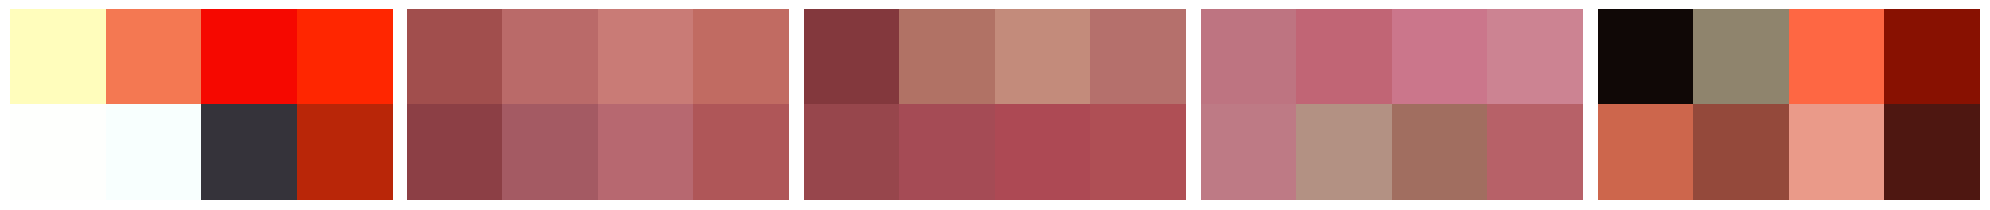

In [7]:
# Sample Data Visualization
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_images, _ = next(train_generator)
plot_images(sample_images[:5])

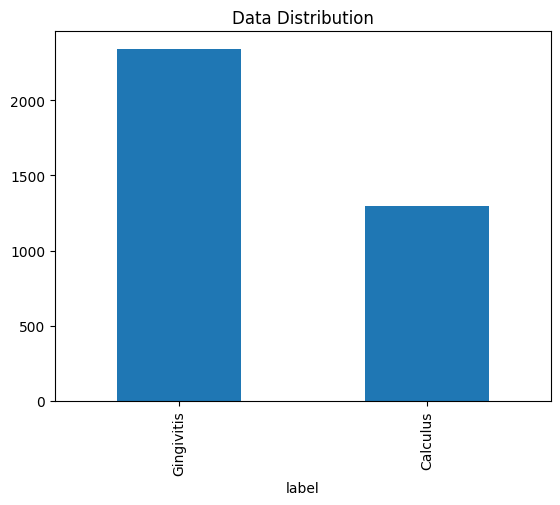

In [8]:
# Data Distribution Visualization
data_df['label'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.show()


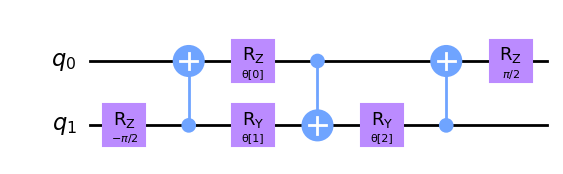

In [9]:
# Defining Convolutional and Pooling Layers for QCNN
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

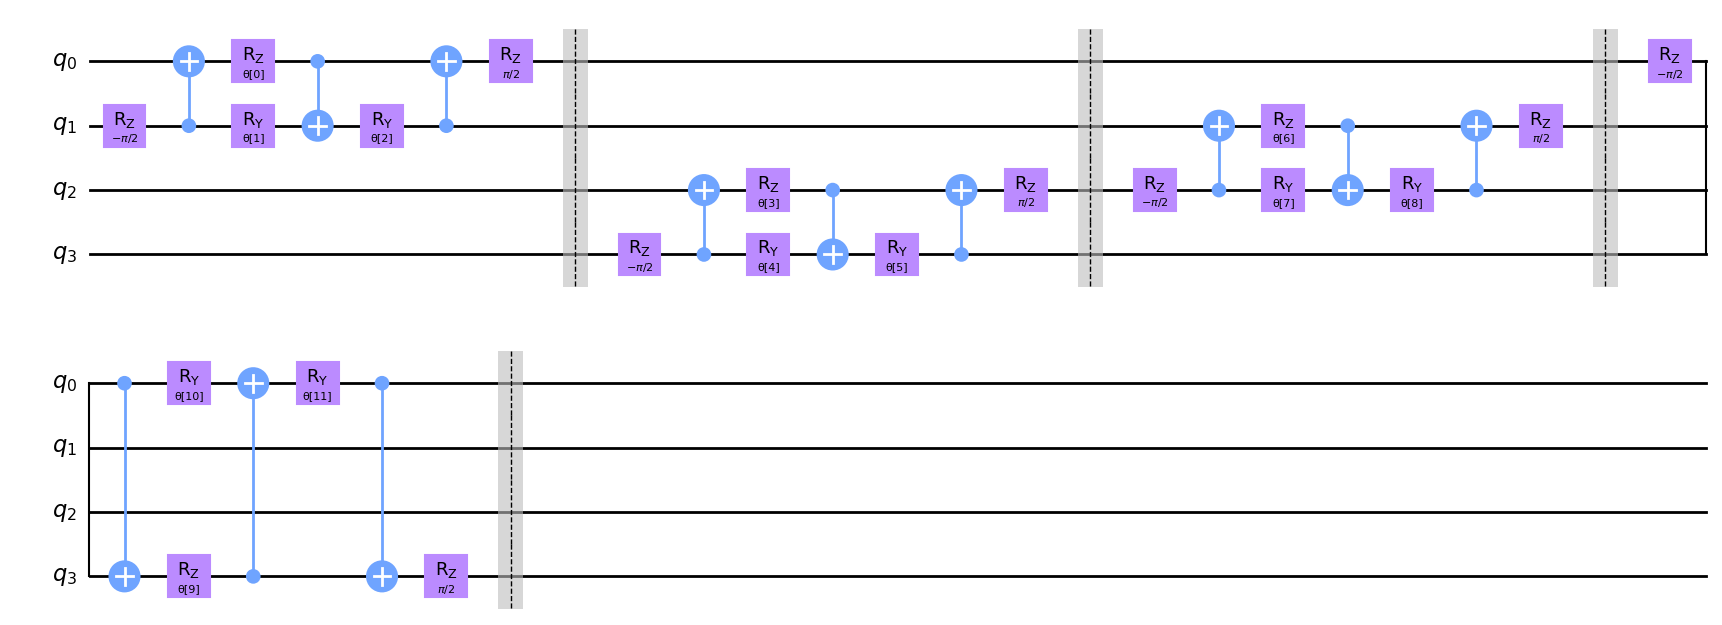

In [10]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

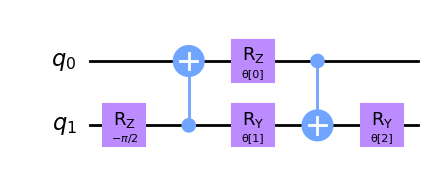

In [11]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")


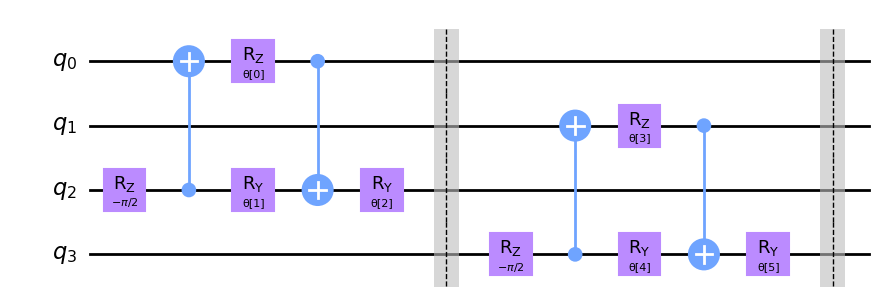

In [12]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

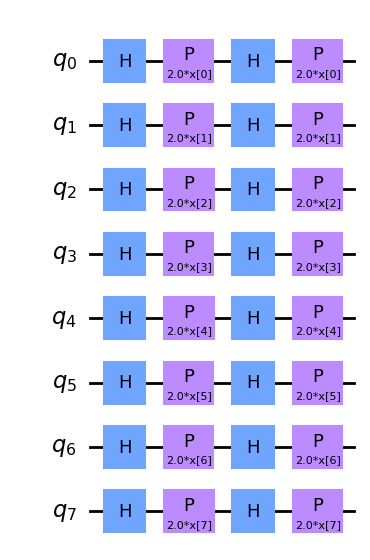

In [13]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [14]:
# Building the QCNN Model
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

<ipython-input-14-479f0d5782b5>:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


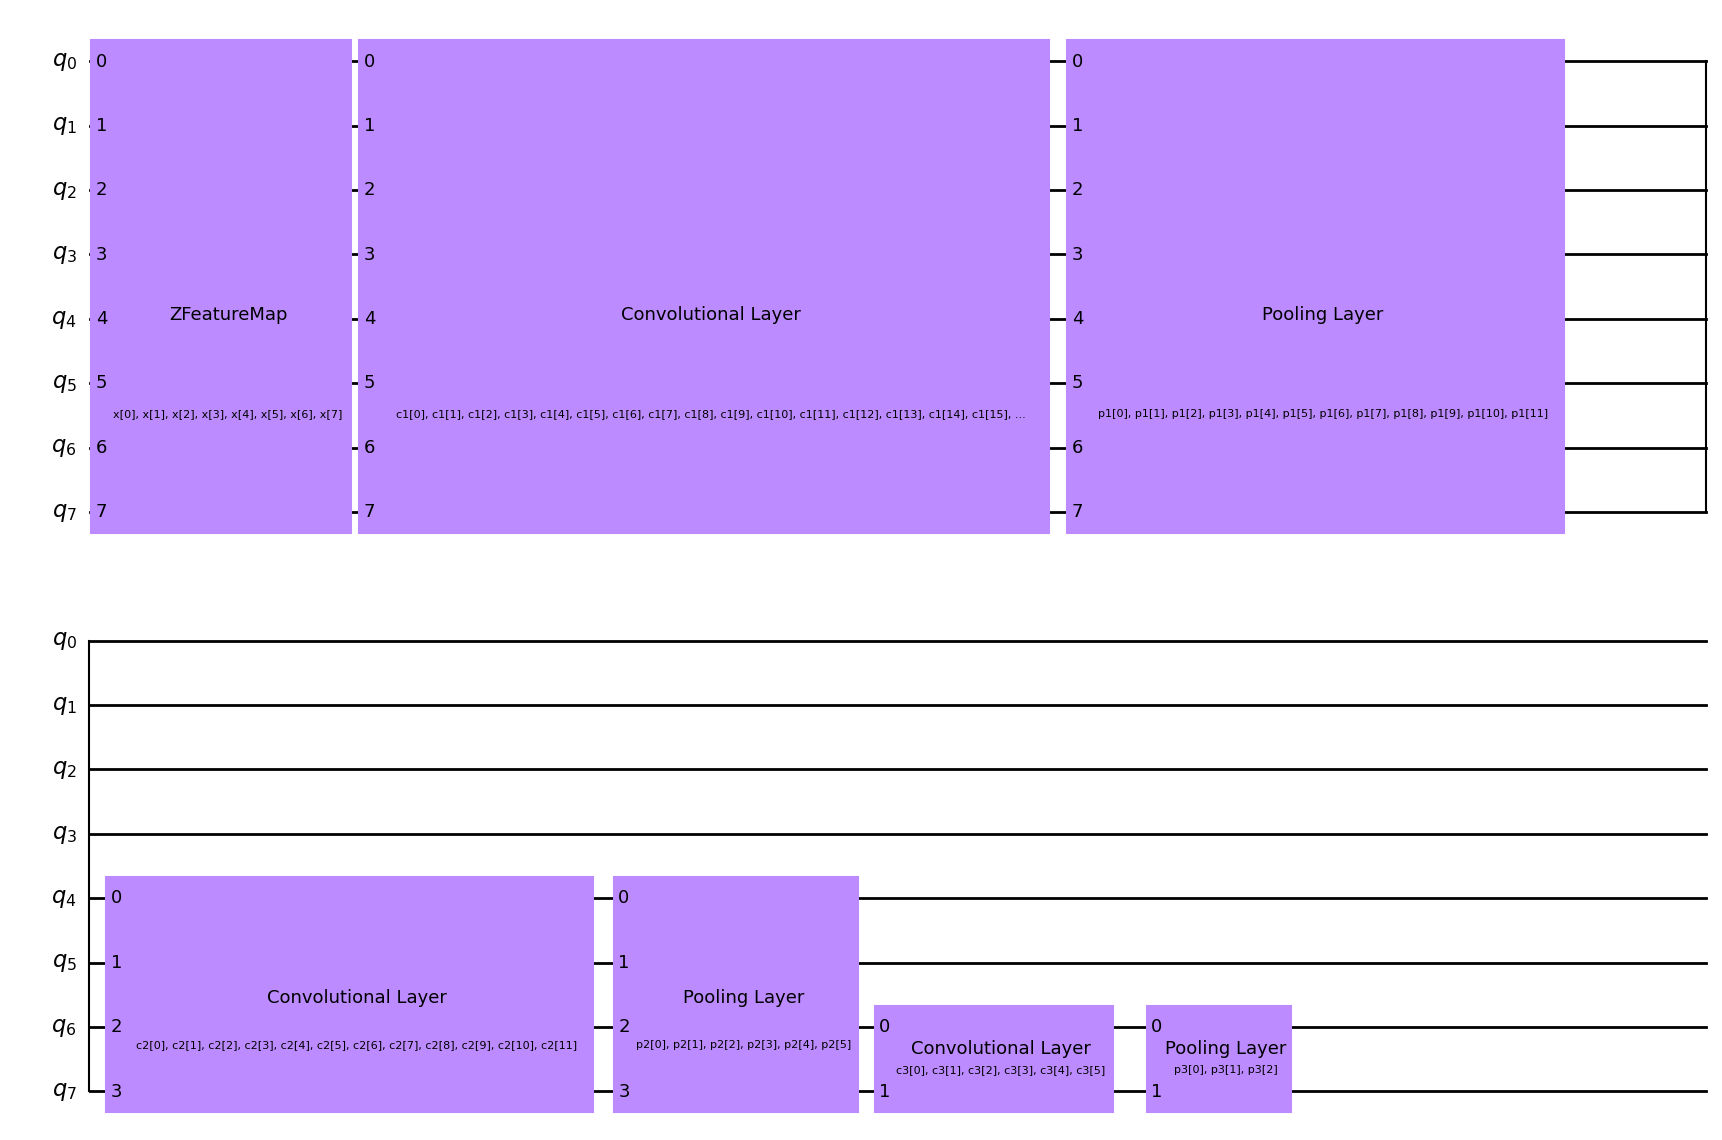

In [15]:
circuit.draw("mpl", style="clifford")

Accuracy from the train data: 59.38%


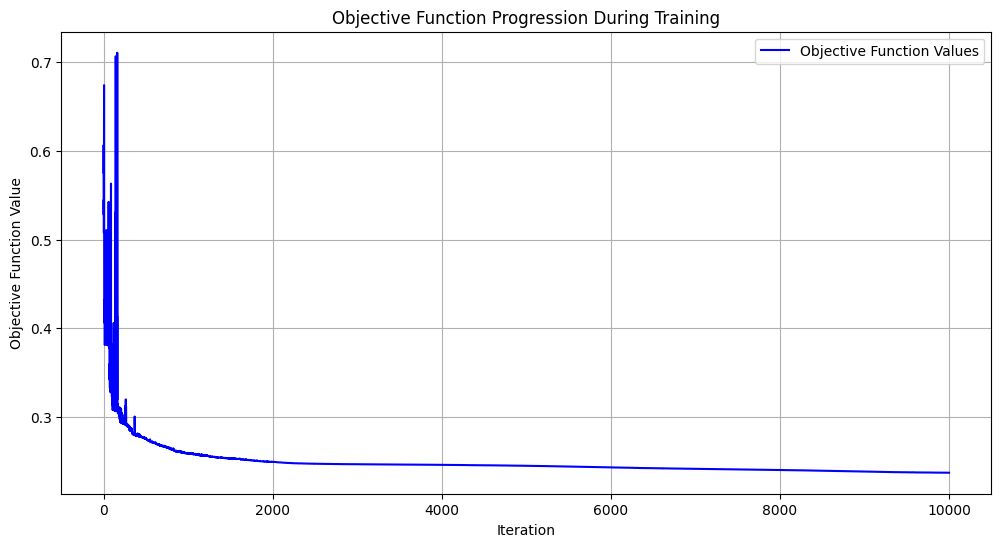

In [16]:
# Training the QCNN
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
# Callback to store objective function values during training
objective_func_vals = []

def callback_graph(weight_params, obj_func_eval):
    """Callback function to store objective function values."""
    global objective_func_vals
    # Store the objective function value
    objective_func_vals.append(obj_func_eval)

# Initialize random weights if the initial_point file is missing
initial_point = np.random.rand(len(qnn.weight_params))

# Define the Neural Network Classifier
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=10000),
    callback=callback_graph,
    initial_point=initial_point,
)

# Fetch data and correct reshaping
train_data = next(train_generator)  # Get one batch of data
x_train, y_train = train_data[0], train_data[1]  # Extract input and labels

# Flatten each image to match the input shape
x_train = x_train.reshape(-1, 2*4*3)  # Reshape to match the number of qubits (2x4 pixels, 3 channels)

# Use only the first 8 features (from the first 8 qubits)
x_train = x_train[:, :8]

# Fit the classifier to the training data
classifier.fit(x_train, y_train)

# Print accuracy
accuracy = np.round(100 * classifier.score(x_train, y_train), 2)
print(f"Accuracy from the train data: {accuracy}%")

# Plot the objective function values on a single graph
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, label="Objective Function Values", color="blue")
plt.title("Objective Function Progression During Training")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.grid()
plt.show()

In [17]:
# Testing the QCNN
test_data = next(test_generator)  # Get one batch of data
x_test, y_test = test_data[0], test_data[1]

# Flatten each image to match input shape
x_test = x_test.reshape(-1, 2*4*3)  # Reshape to match the number of qubits (2x4 pixels, 3 channels)

# Use only the first 8 features (from the first 8 qubits)
x_test = x_test[:, :8]

y_predict = classifier.predict(x_test)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x_test, y_test), 2)}%")

Accuracy from the test data : 68.75%


**References**

[1] Cong, I., Choi, S. & Lukin, M.D. Quantum convolutional neural networks. Nat. Phys. 15, 1273–1278 (2019). https://doi.org/10.1038/s41567-019-0648-8

[2] IBM Convolutional Neural Networks https://www.ibm.com/cloud/learn/convolutional-neural-networks

[3] Vatan, Farrokh, and Colin Williams. “Optimal quantum circuits for general two-qubit gates.” Physical Review A 69.3 (2004): 032315.

This code is a part of a Qiskit project

© Copyright IBM 2017, 2024.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.

**Version Information**

Software	Version

qiskit	1.3.1

qiskit_machine_learning	0.8.2

System information

Python version	3.10.15

OS	Linux

